In [59]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import pandas as pd
from scipy import stats

import constants as c
import helpers as h

from logger import setup_logger 
log = setup_logger("external-covariate-correlations-analysis")
log.setLevel("INFO")
log.info("Modules loaded.")

2025-02-05 19:47:43 - external-covariate-correlations-analysis - INFO - Modules loaded.


In [60]:
# enable latex plotting if true 
h.latex(True)

2025-02-05 19:47:43 - analysis-helpers - INFO - Enabling LaTeX for matplotlib.


In [61]:
analysis_df = pd.read_csv(c.CURRENT_NO_COVARIATES_DF)
analysis_df = h.add_helper_cols(analysis_df)


2025-02-05 19:47:43 - analysis-helpers - INFO - Found 192 tracts with at least one FloodNet sensor.
2025-02-05 19:47:43 - analysis-helpers - INFO - Found 2171 311 requests.
2025-02-05 19:47:43 - analysis-helpers - INFO - Found 878 tracts with at least one 311 report.
2025-02-05 19:47:43 - analysis-helpers - INFO - Found 1001 tracts with no DEP flooding.


Text(0.5, 1.0, 'log(p_y)')

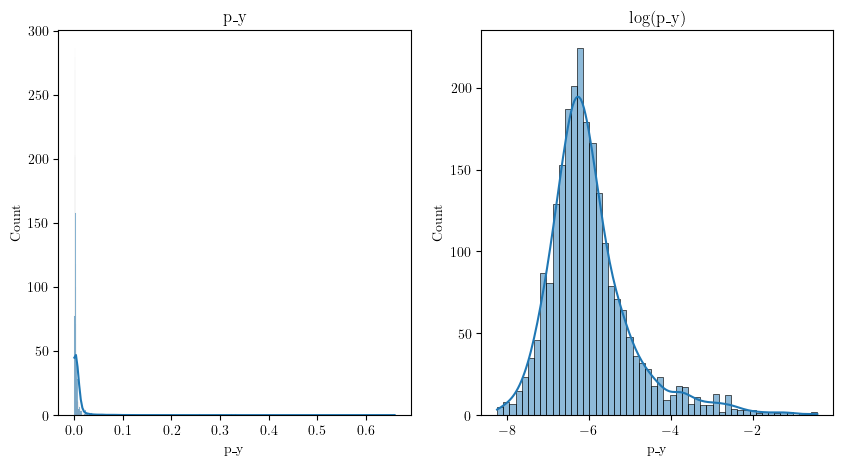

In [62]:
# histogram of p_y, log(p_y)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(analysis_df['p_y'], ax=axs[0], kde=True)
axs[0].set_title("p_y")
sns.histplot(np.log(analysis_df['p_y']), ax=axs[1], kde=True)
axs[1].set_title("log(p_y)")


In [63]:
# log transform p_y 
analysis_df['p_y'] = analysis_df['p_y'].apply(lambda x: np.log(x))

In [64]:
COVARIATES = [
    'any_311_report',
    'n_311_reports',
    'any_sensors',
    'n_floodnet_sensors',
    'dep_moderate_1_frac',
    'dep_moderate_2_frac',
    'ft_elevation_min',
    'ft_elevation_mean',
    'ft_elevation_max'
]

In [65]:
# Define regression parameters for each covariate
regression_params = {
    'any_311_report': {'logistic': True, 'fit_reg': True, 'skewed': False},
    'n_311_reports': {'logistic': False, 'fit_reg': True, 'skewed': True},
    'any_sensors': {'logistic': True, 'fit_reg': True, 'skewed': False},
    'n_floodnet_sensors': {'logistic': False, 'fit_reg': True, 'skewed': True},
    'dep_moderate_1_frac': {'logistic': False, 'fit_reg': True, 'skewed': True},
    'dep_moderate_2_frac': {'logistic': False, 'fit_reg': True, 'skewed': True},
    'ft_elevation_min': {'logistic': False, 'fit_reg': True, 'skewed': True},
    'ft_elevation_mean': {'logistic': False, 'fit_reg': True, 'skewed': False},
    'ft_elevation_max': {'logistic': False, 'fit_reg': True, 'skewed': True}
}

row_mapping = {
    'any_311_report': 'Any 311 Report in Tract?',
    'n_311_reports': '\# of 311 Reports in Tract',
    'any_sensors': 'Any FloodNet sensors in Tract?',
    'n_floodnet_sensors': '\# of FloodNet sensors in Tract',
    'dep_moderate_1_frac': r'Frac. Pred. Shallow Flooding [${ft}^2$]',
    'dep_moderate_2_frac': r'Frac. Pred. Deep Flooding [${ft}^2$]',
    'ft_elevation_min': 'Minimum elevation in Tract [ft]',
    'ft_elevation_mean': 'Mean elevation in Tract[ft]',
    'ft_elevation_max': 'Maximum elevation in Tract [ft]'
}

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

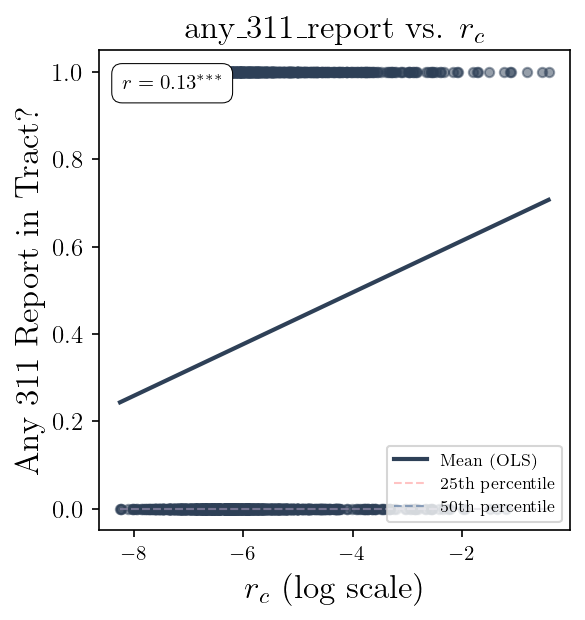

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

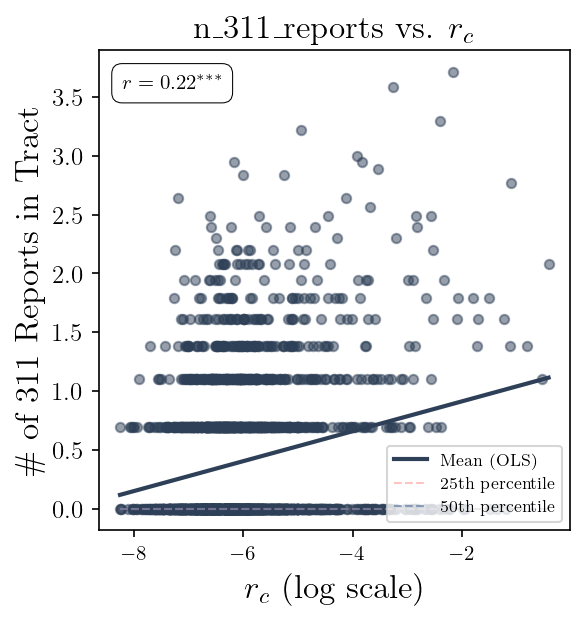

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

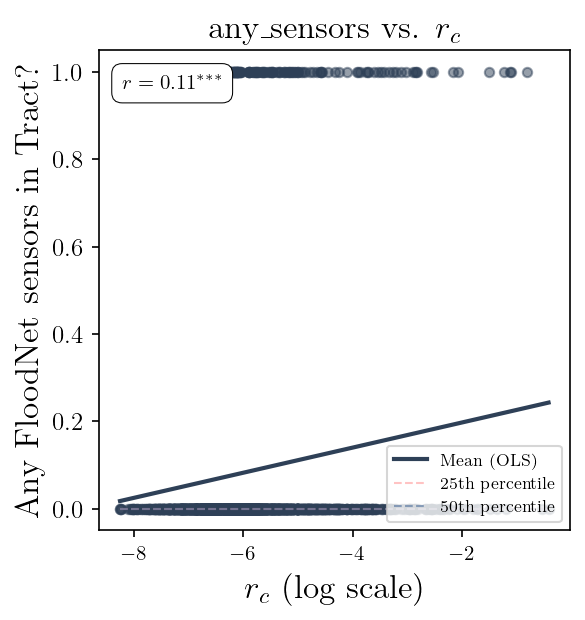

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

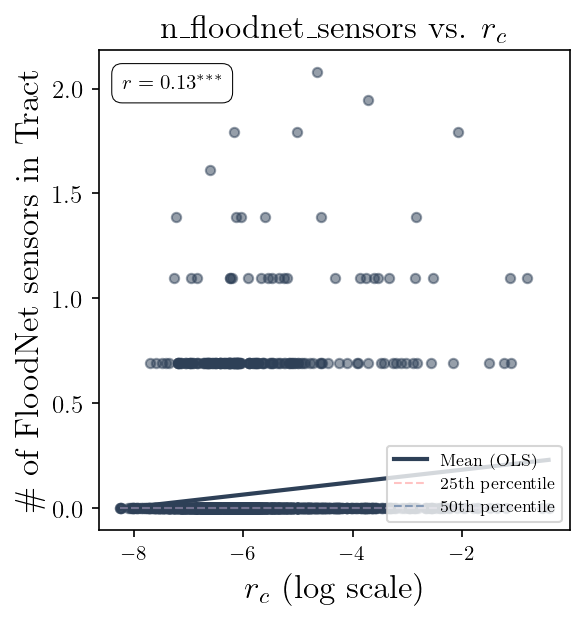

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

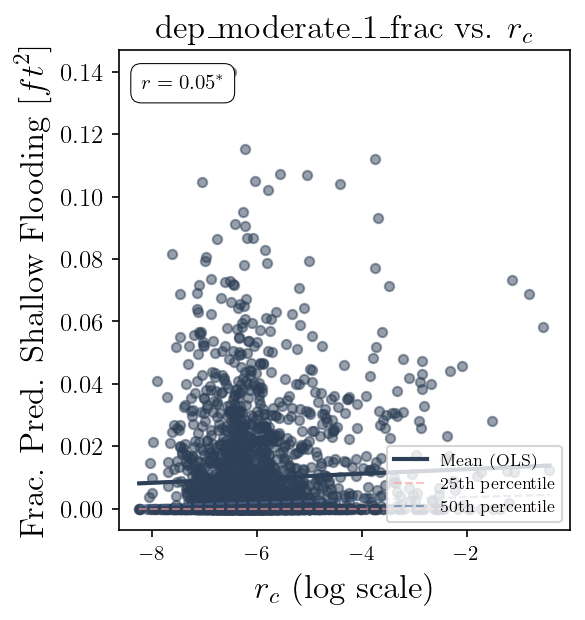

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

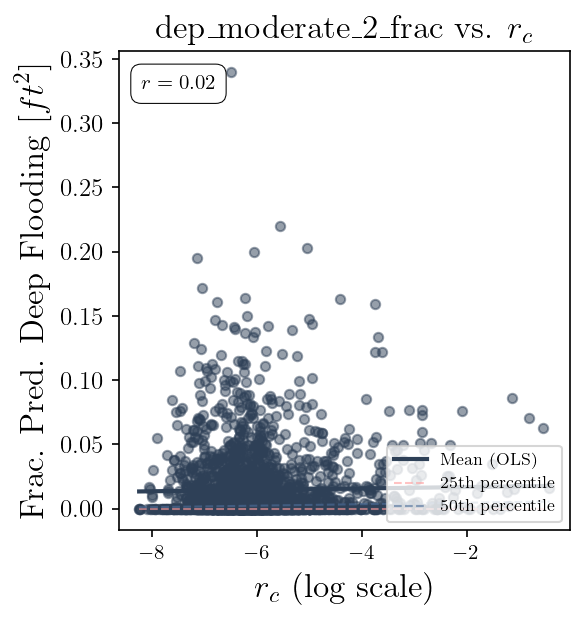

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

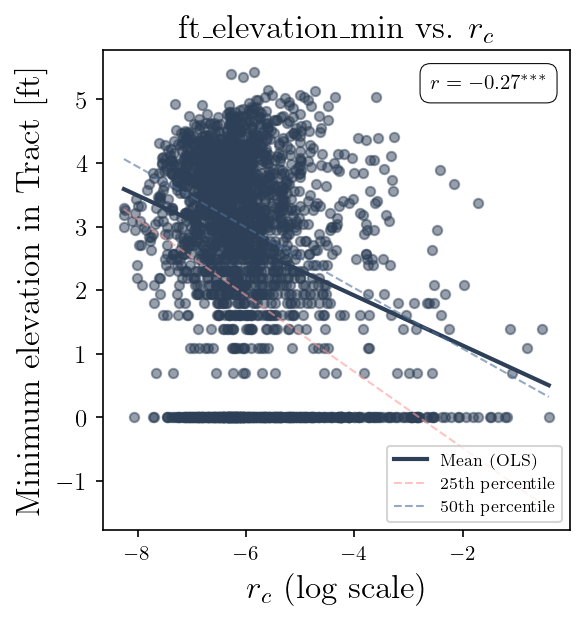

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

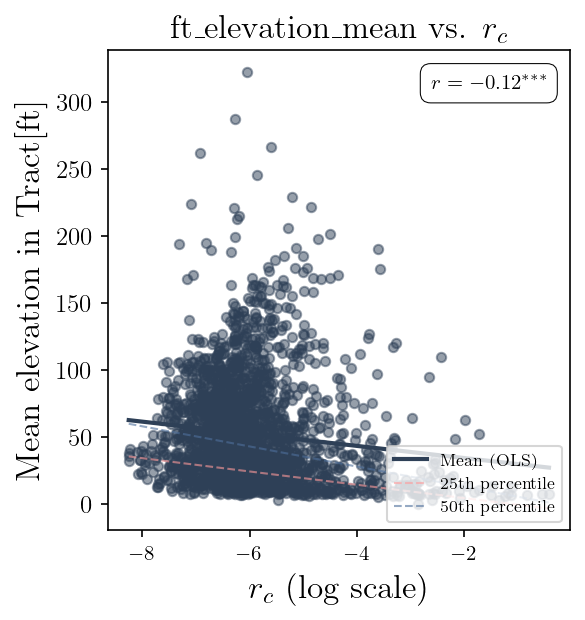

/tmp/ipykernel_2590913/3667702162.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals
/tmp/ipykernel_2590913/3667702162.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = results.params[0] + results.params[1] * x_vals

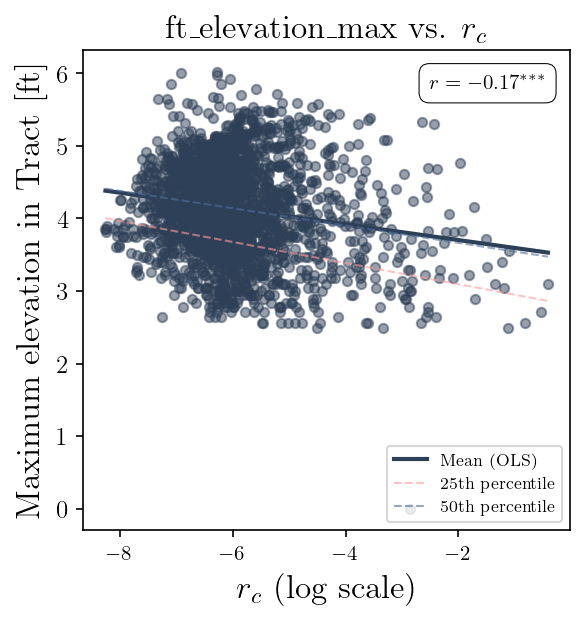

In [66]:
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

def plot_quantile_regression(df, x_col, y_col, quantiles=[0.25, 0.5, 0.75],  fig_size=(4, 4)):
    """
    Cleaner visualization of quantile regression analysis.
    """
    data = df.copy()
    log_transform = regression_params[y_col]['skewed']
    # Log transform if requested (keeping your original approach)
    if log_transform:
            
        if min(data[y_col]) <= 0:
            data[y_col] = np.log1p(data[y_col])
        else:
            data[y_col] = np.log(data[y_col])
    
    # Create figure with your original size
    plt.figure(figsize=fig_size, dpi=150)
    
    # Plot scatter with your original styling
    plt.scatter(data[x_col], data[y_col], alpha=0.5, color='#2E4057', s=20)
    
    # Fit and plot quantile regressions
    x_vals = np.linspace(data[x_col].min(), data[x_col].max(), 100)
    
    # Using a more subtle color palette
    colors = ['#2E4057', '#FF9B9B', '#4F709C']  # Main line and quantiles
    
    # First plot OLS
    model_ols = sm.OLS(data[y_col], sm.add_constant(data[x_col])).fit()
    y_pred_ols = model_ols.params[0] + model_ols.params[1] * x_vals
    plt.plot(x_vals, y_pred_ols, color=colors[0], linewidth=2, 
            label='Mean (OLS)')
    
    # Then plot quantiles with thinner, more transparent lines
    for q, color in zip(quantiles, colors[1:]):
        model = QuantReg(data[y_col], sm.add_constant(data[x_col]))
        results = model.fit(q=q)
        
        y_pred = results.params[0] + results.params[1] * x_vals
        plt.plot(x_vals, y_pred, color=color, alpha=0.6, linewidth=1,
                linestyle='--', label=f'{int(q*100)}th percentile')
    
    # Calculate Pearson correlation for the text box
    r, p = stats.pearsonr(data[x_col], data[y_col])
    
    # Add correlation text box with your original formatting
    if p < 0.001:
        text = f'$r = {r:.2f}^{{***}}$'
    elif p < 0.01:
        text = f'$r = {r:.2f}^{{**}}$'
    elif p < 0.05:
        text = f'$r = {r:.2f}^{{*}}$'
    else:
        text = f'$r = {r:.2f}$'
    
    # Position based on correlation sign
    x_pos = 0.05 if r > 0 else 0.95
    plt.text(x_pos, 0.95, text, 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', 
                      edgecolor='black',
                      alpha=1.0,
                      pad=3,
                      linewidth=0.5,
                      boxstyle='round,pad=0.5'),
             verticalalignment='top',
             horizontalalignment='left' if r > 0 else 'right')
    
    plt.xlabel('$r_c$ (log scale)', fontsize=16)
    plt.ylabel(row_mapping[y_col], fontsize=16)
    plt.yticks(fontsize=12)
    
    # Add legend with smaller font
    plt.legend(fontsize=8, loc='lower right')
    
    plt.tight_layout()
    
    return plt.gca()

# Example usage with your original loop
for cov in COVARIATES:
    fig = plot_quantile_regression(analysis_df, 'p_y', cov)
    fig.set_title(f'{cov} vs. $r_c$', fontsize=16)
    plt.show()
    plt.close()

Text(0.5, 1.02, 'Original and Log-transformed Distributions of Covariates')

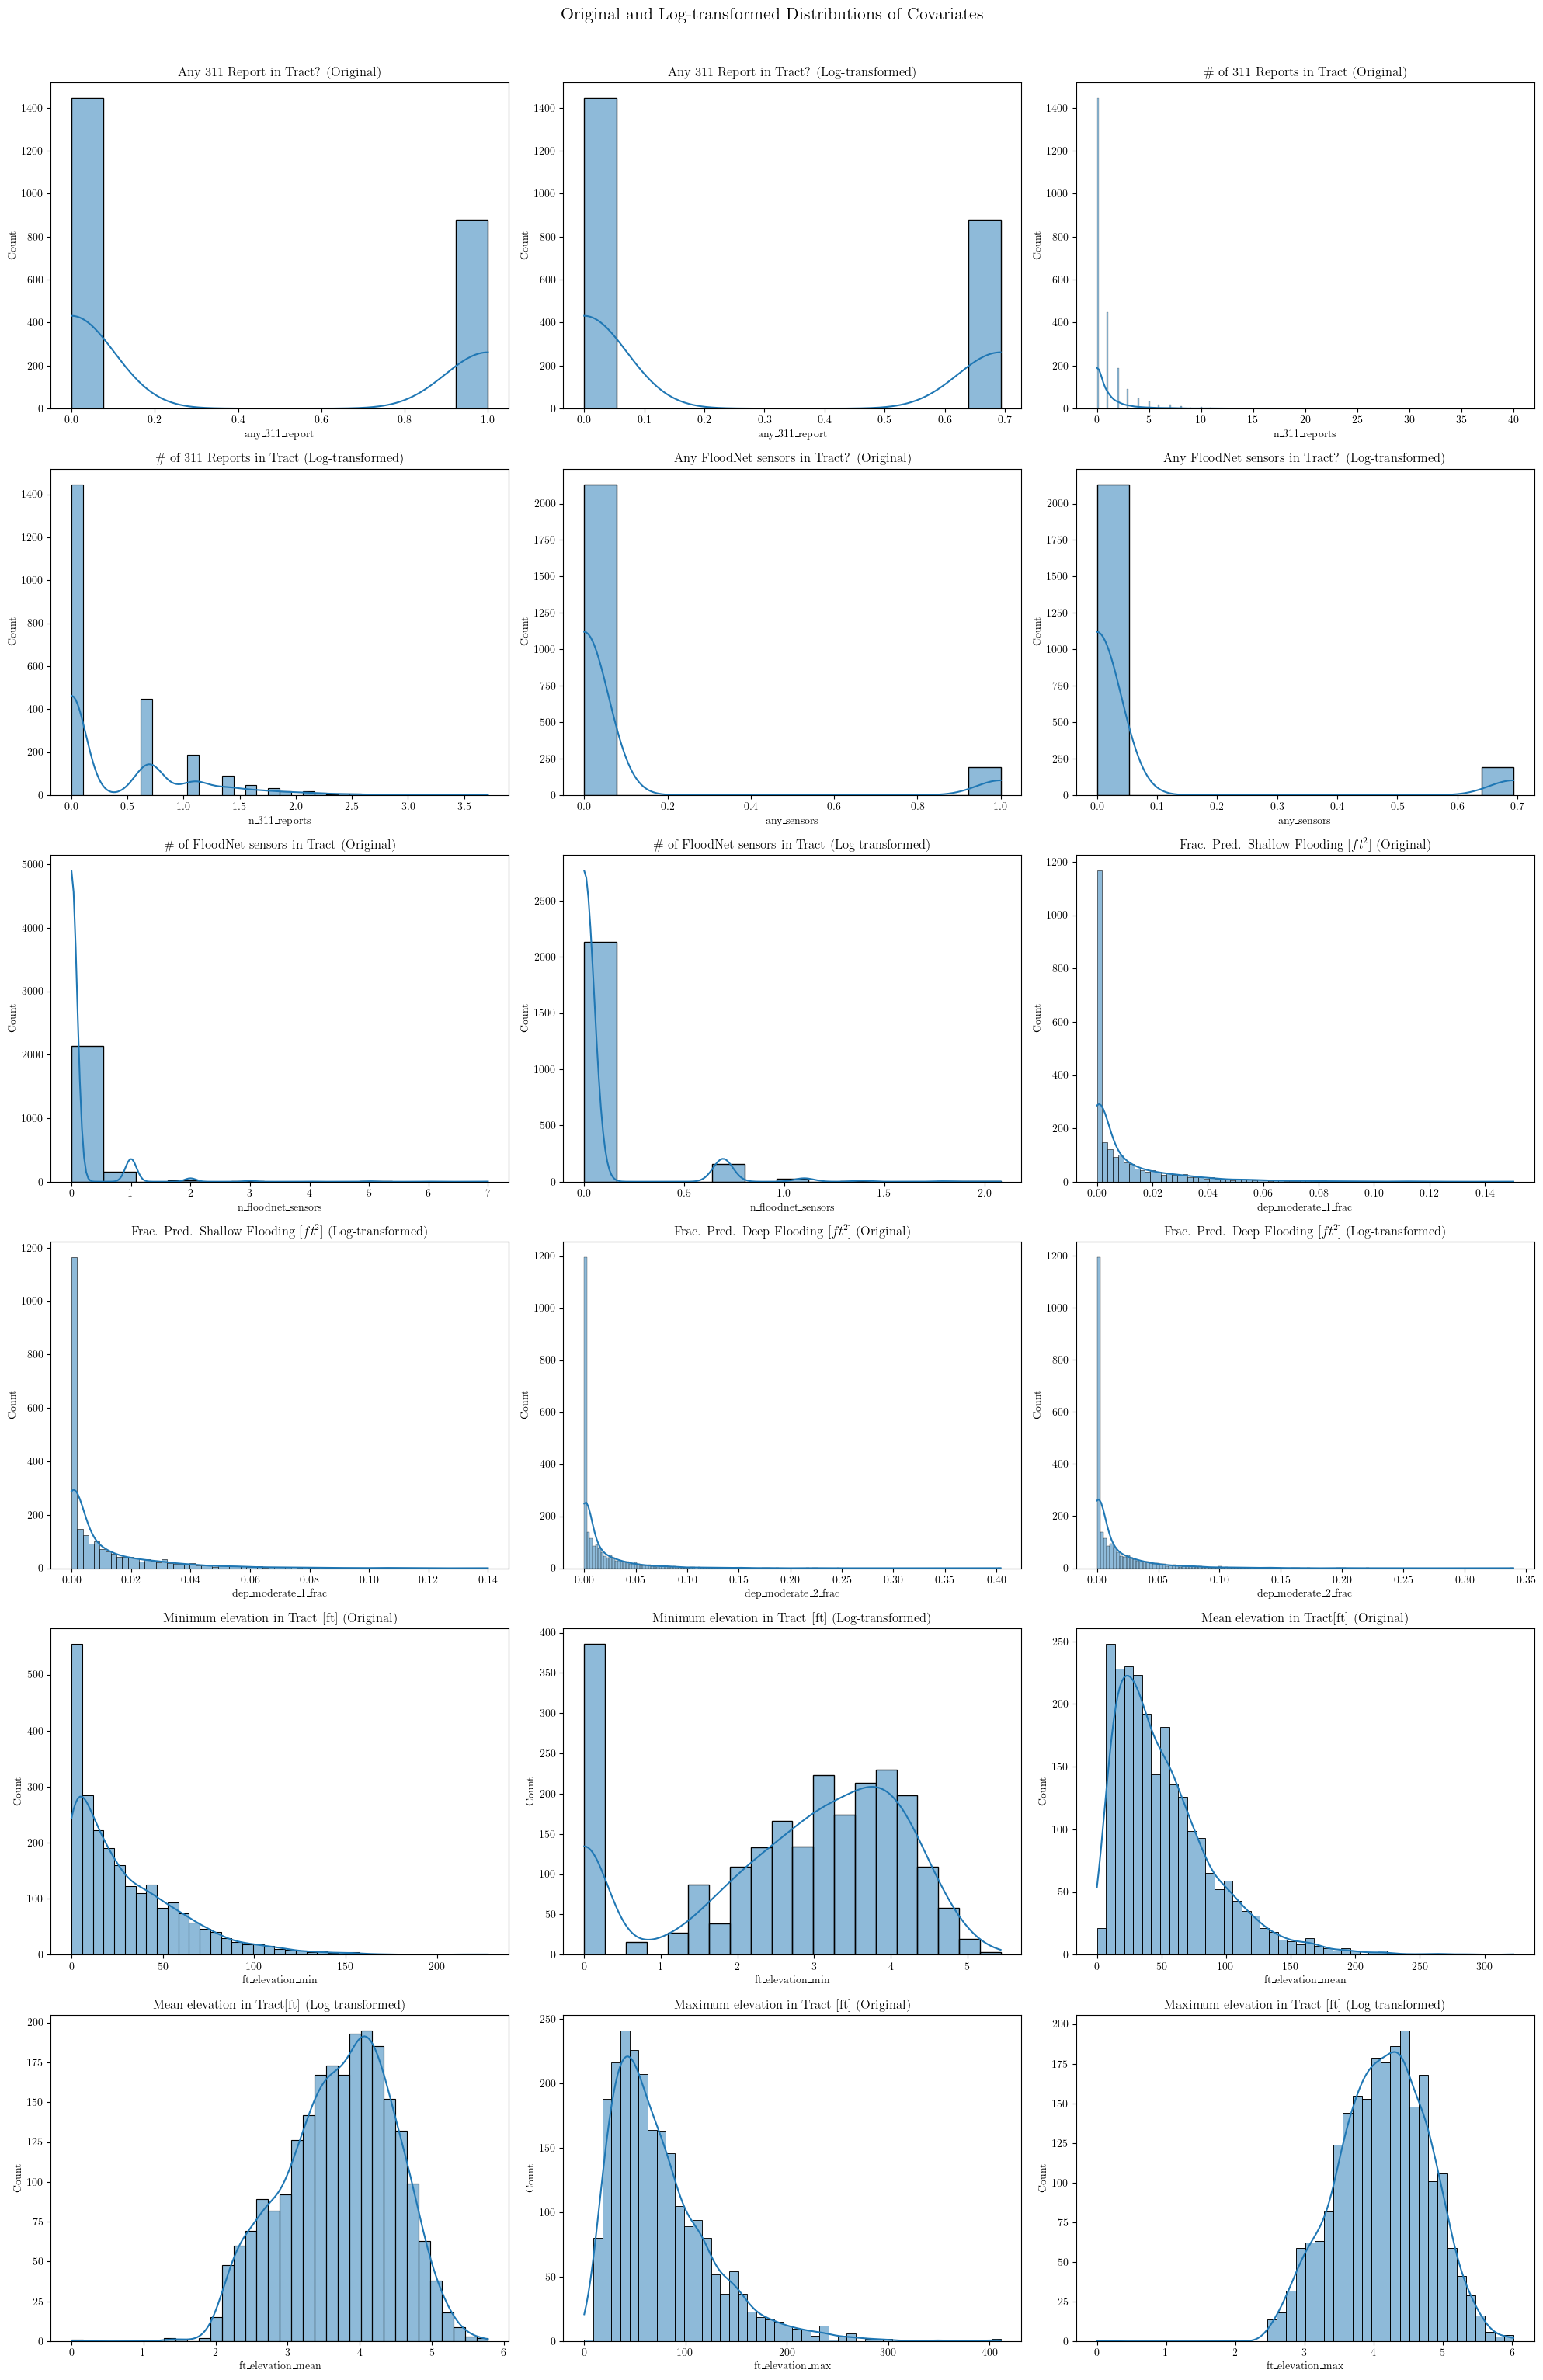

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a 6x3 grid (3 columns, 6 rows for original + log pairs)
fig, axs = plt.subplots(6, 3, figsize=(20, 30))

# Flatten the axes for easier indexing
axs_flat = axs.flatten()

for i, cov in enumerate(COVARIATES):
    # Original distribution (top row of pair)
    ax_orig = axs_flat[i*2]
    sns.histplot(analysis_df[cov], ax=ax_orig, kde=True)
    ax_orig.set_title(f'{row_mapping[cov]} (Original)')
    
    # Log-transformed distribution (bottom row of pair)
    ax_log = axs_flat[i*2 + 1]
    # Add small constant to handle zeros/negative values if present
    log_data = np.log(analysis_df[cov] + (1 if min(analysis_df[cov]) <= 0 else 0))
    sns.histplot(log_data, ax=ax_log, kde=True)
    ax_log.set_title(f'{row_mapping[cov]} (Log-transformed)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Optional: Add a main title
fig.suptitle('Original and Log-transformed Distributions of Covariates', 
             y=1.02, 
             fontsize=16)

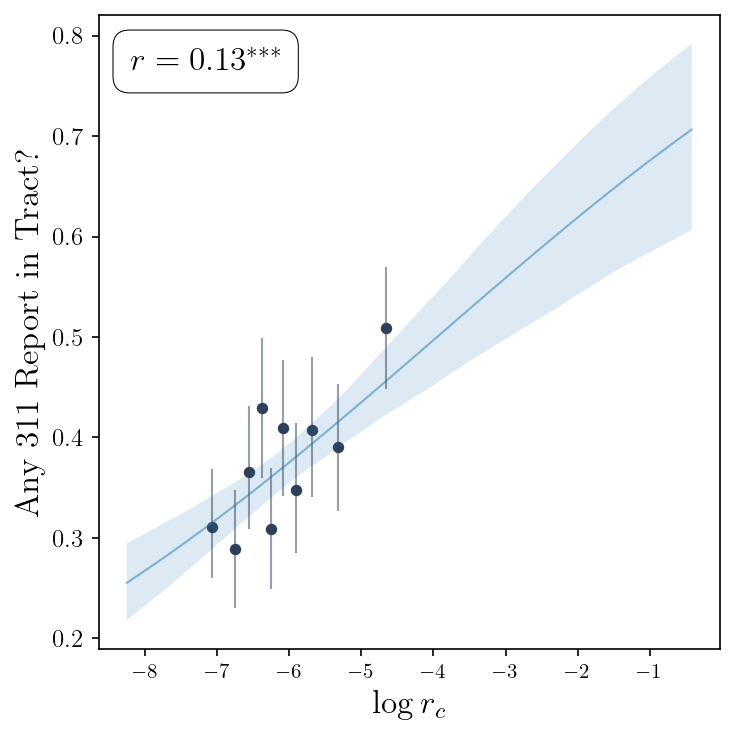

2025-02-05 19:47:51 - external-covariate-correlations-analysis - INFO - Log transforming n_311_reports


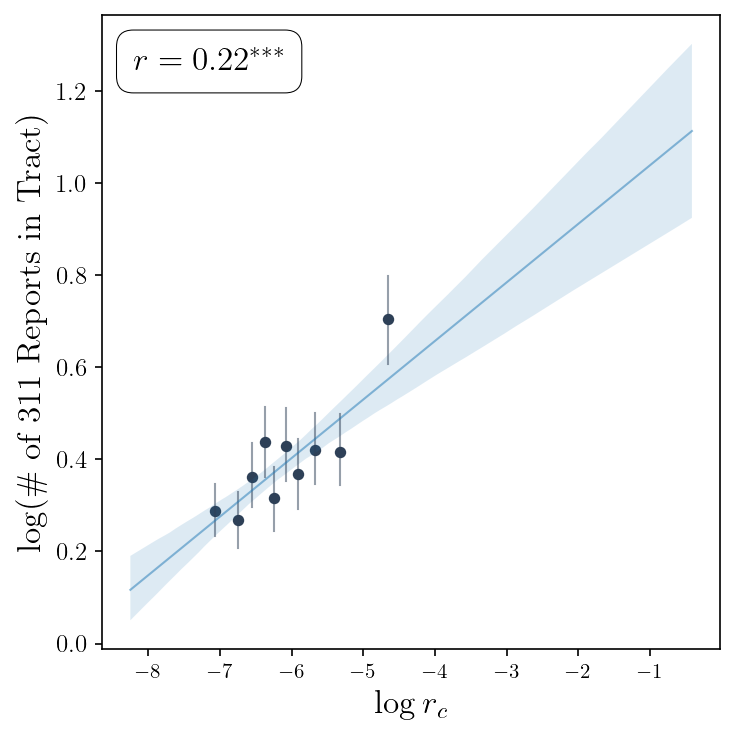

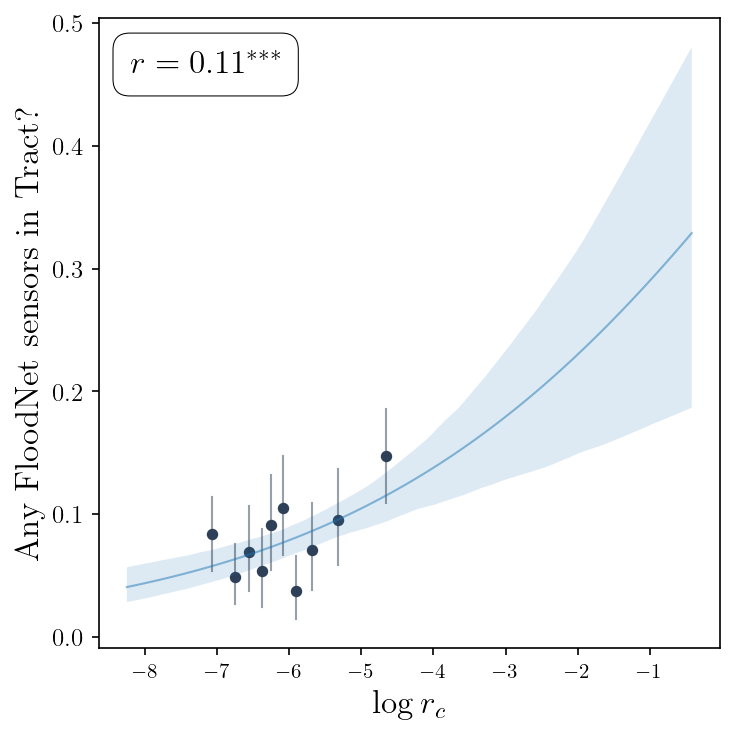

2025-02-05 19:47:54 - external-covariate-correlations-analysis - INFO - Log transforming n_floodnet_sensors


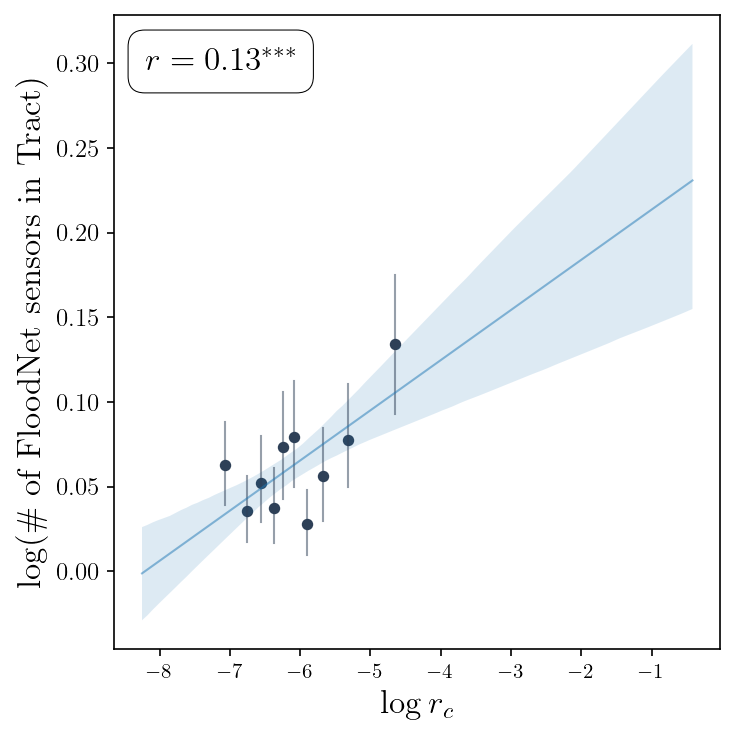

2025-02-05 19:47:54 - external-covariate-correlations-analysis - INFO - Log transforming dep_moderate_1_frac


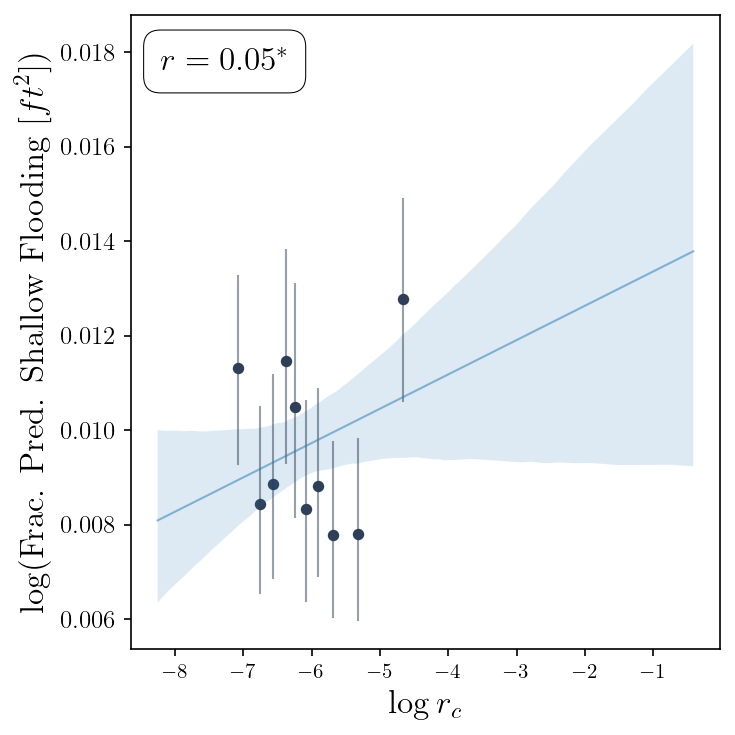

2025-02-05 19:47:55 - external-covariate-correlations-analysis - INFO - Log transforming dep_moderate_2_frac


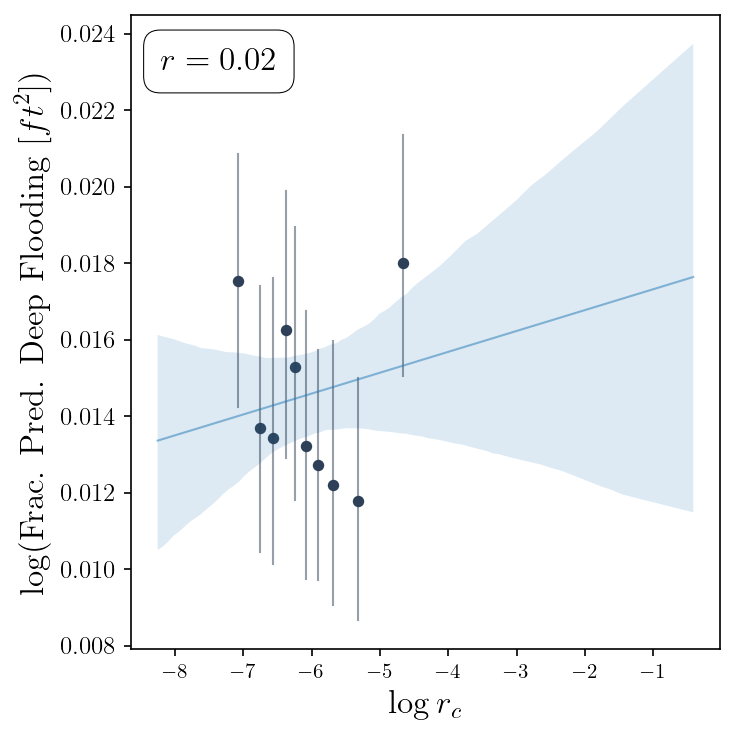

2025-02-05 19:47:55 - external-covariate-correlations-analysis - INFO - Log transforming ft_elevation_min


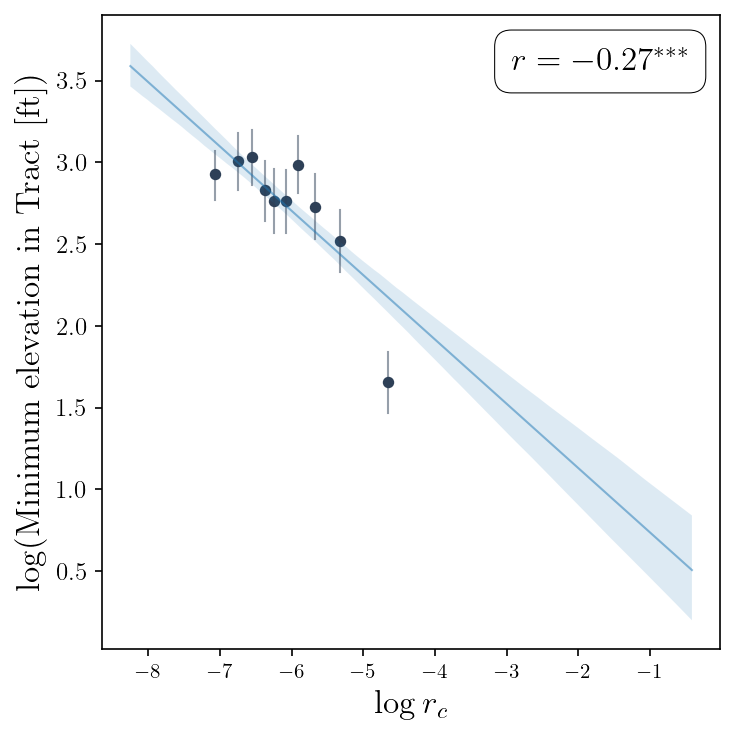

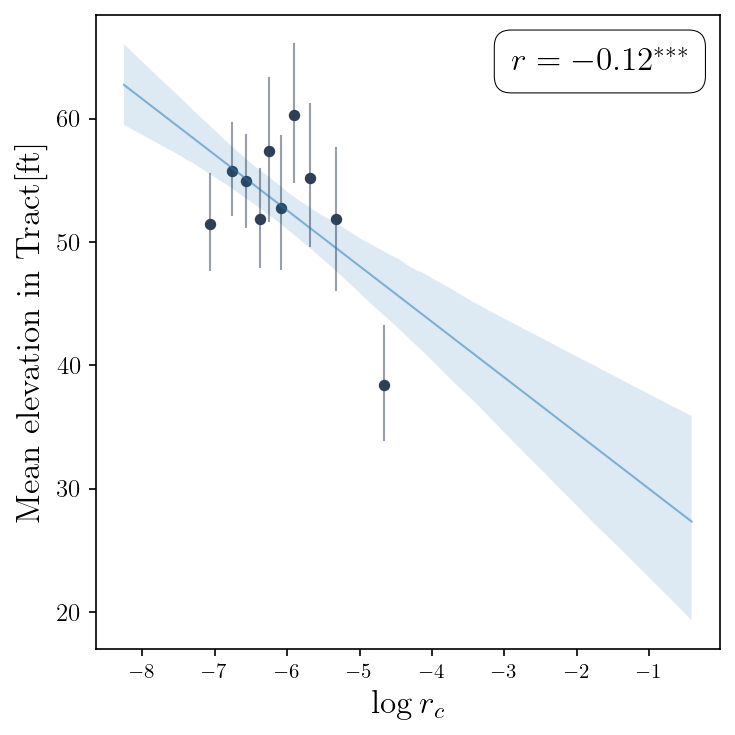

2025-02-05 19:47:57 - external-covariate-correlations-analysis - INFO - Log transforming ft_elevation_max


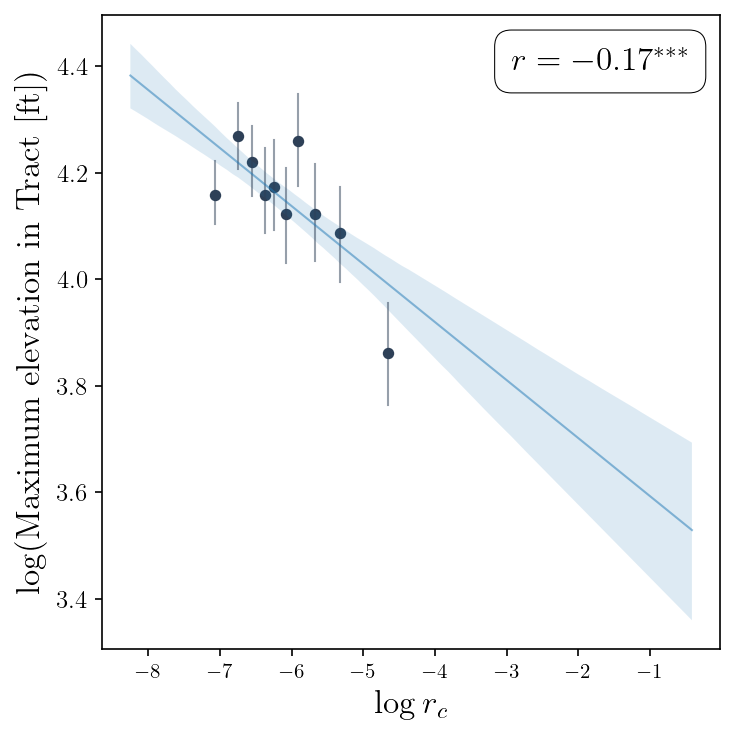

In [68]:
import statsmodels as sm

#analysis_df = analysis_df[(analysis_df['p_y'] > analysis_df['p_y'].quantile(0.01)) & (analysis_df['p_y'] < analysis_df['p_y'].quantile(0.99))]

# Get the actual range of x values
x_min = analysis_df['p_y'].min()
x_max = analysis_df['p_y'].max()

for cov in COVARIATES:
    plt.figure(figsize=(5, 5), dpi=150)
    
    # Get regression parameters for this covariate
    params = regression_params.get(cov, {'logistic': False, 'fit_reg': True, 'skewed': False})

    if params['skewed']:
        log.info(f"Log transforming {cov}")
        analysis_df[cov] = analysis_df[cov].apply(lambda x: x + 1)
        analysis_df[cov] = analysis_df[cov].apply(lambda x: np.log(x))

    
    ax = sns.regplot(
        data=analysis_df,
        x='p_y',
        y=cov,
        x_bins=10,
        logistic=params['logistic'],
        fit_reg=params['fit_reg'],
        scatter_kws={'alpha': 1, 'color': '#2E4057', 's': 20},
        truncate=True,  # This ensures the line stays within data bounds
        x_ci="ci",  # Keeps confidence intervals
    )
    
    # Additional constraint: manually remove any regression line segments outside data range
    if ax.lines:  # Check if there's a regression line
        line = ax.lines[0]
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        mask = (x_data >= x_min) & (x_data <= x_max)
        line.set_xdata(x_data[mask])
        line.set_ydata(y_data[mask])
    
    # Make the error bars thinner
    for line in ax.lines:
        line.set_linewidth(1)
        line.set_alpha(0.5)
    
    # Calculate Pearson correlation
    r, p = stats.pearsonr(analysis_df['p_y'], analysis_df[cov])
    
    # Add correlation text box
    if p < 0.001:
        text = f'$r = {r:.2f}^{{***}}$'
    elif p < 0.01:
        text = f'$r = {r:.2f}^{{**}}$'
    elif p < 0.05:
        text = f'$r = {r:.2f}^{{*}}$'
    else:
        text = f'$r = {r:.2f}$'
    
    # Position based on correlation sign
    x_pos = 0.05 if r > 0 else 0.95
    plt.text(x_pos, 0.95, text, 
             transform=ax.transAxes, 
             bbox=dict(facecolor='white', 
                      edgecolor='black',
                      alpha=1.0,
                      pad=3,
                      linewidth=0.5,
                      boxstyle='round,pad=0.5'),
             verticalalignment='top',
             horizontalalignment='left' if r > 0 else 'right',
             fontsize=16)
    
    #plt.xscale('log')
    plt.xlabel(r'$\log{r_c}$', fontsize=16)  # This is good as is
    if params['skewed']:
        plt.ylabel(r'$\log($' + row_mapping[cov] + r'$)$', fontsize=16)
    else: 
        plt.ylabel(row_mapping[cov], fontsize=16)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{c.PAPER_PATH}/figures/external_covariates_corrs_{cov}.png', dpi=150, bbox_inches='tight')
    plt.show()